# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [6]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://www.radikant.com'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://www.radikant.com
https://www.radikant.com/leistungen/
https://www.radikant.com/
https://www.radikant.com/corporate-design-agentur/
https://www.radikant.com/projekte/devk-corporate-illustration/
https://www.radikant.com/news/ausbildungen-bei-radikant/
https://www.radikant.com/datenschutz/
https://www.radikant.com/projekte/
https://www.radikant.com/cookie-einstellungen/
https://www.radikant.com/projekte/brand-design-team-deutsche-telekom/
https://www.radikant.com/news/
https://www.radikant.com/agentur/
https://www.radikant.com/glossar/
https://www.radikant.com/leistungen/branding/
https://www.radikant.com/jobs/
https://www.radikant.com/leistungen/markenportal/
https://www.radikant.com/news/design-fuer-die-menschenrechte/
https://www.radikant.com/impressum/
https://www.radikant.com/wissen/design-systeme/
https://www.radikant.com/projekte/hype-innovation-corporate-design/
https://www.radikant.com/leistungen/user-experience-design-ux/
https://www.radikant.com/kontakt/
https://www.ra

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [9]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if parsed.title.string else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

extracted: https://www.radikant.com/projekte/corporate-design-hype Projekte | Radikant 191 Token, 536
extracted: https://www.radikant.com/projekte/corporate-design-dglr Corporate Design DGLR | Radikant 676 Token, 1827
extracted: https://www.radikant.com/glossar/markenidentitaet Markenidentität - Definition | Radikant | Radikant 113 Token, 280
extracted: https://www.radikant.com/glossar/storytelling Storytelling - Definition | Radikant | Radikant 228 Token, 631
extracted: https://www.radikant.com/news/wertvolle-verstaerkung Wertvolle Verstärkung | Radikant 251 Token, 662
extracted: https://www.radikant.com/jobs/vertriebsassistenz-wmx Vertriebsassistenz (w/m/x) | Radikant 1595 Token, 4017
extracted: https://www.radikant.com/corporate-design-agentur Corporate Design Agentur | Radikant 4005 Token, 10860
extracted: https://www.radikant.com/wissen/interview-mit-till-oyen-creative-director-radikant Interview mit Till Oyen | Creative Director Radikant | Radikant 3006 Token, 8134
extracted: htt

extracted: https://www.radikant.com/wissen/wie-sieht-ein-optimales-agentur-briefing-aus Wie sieht ein optimales Agentur-Briefing aus? | Radikant 761 Token, 1981
extracted: https://www.radikant.com/projekte/corporate-design-uni-esports Corporate Design UNI esports | Radikant 920 Token, 2608
extracted: https://www.radikant.com/glossar/social-media-marketing Social Media Marketing - Definition | Radikant | Radikant 175 Token, 503
extracted: https://www.radikant.com/projekte/ux-design-sternsinger UX Design Sternsinger | Radikant 1995 Token, 5500
extracted: https://www.radikant.com/glossar/markenbotschaften Markenbotschaften - Definition | Radikant | Radikant 180 Token, 491
extracted: https://www.radikant.com/glossar/familienmarkenstrategie Familienmarkenstrategie - Definition | Radikant | Radikant 180 Token, 493
extracted: https://www.radikant.com/datenschutz Datenschutz | Radikant 12903 Token, 34193
extracted: https://www.radikant.com/wissen/relevant Relevant | Radikant 2658 Token, 7308
e

extracted: https://www.radikant.com/glossar/branded-content Branded Content - Definition | Radikant | Radikant 155 Token, 429
extracted: https://www.radikant.com/wissen/plaedoyer-fuer-ein-strenges-brand-management-mit-kontextgespuer Plädoyer für ein strenges Brand Management mit Kontextgespür | Radikant 2226 Token, 6057
extracted: https://www.radikant.com/glossar/b2c-marke B2C-Marke - Definition | Radikant | Radikant 116 Token, 294
extracted: https://www.radikant.com/glossar/markenfuehrung Markenführung - Definition | Radikant | Radikant 211 Token, 504
extracted: https://www.radikant.com/wissen/wie-marken-real-werden Wie Marken real werden | Radikant 3338 Token, 8772
extracted: https://www.radikant.com/jobs/mid-level-designer-wmx Mid-Level Designer (w/m/x) | Radikant 1095 Token, 2748
extracted: https://www.radikant.com/wissen/design-systeme Design System: Was das ist und welchen Nutzen dieses hat | Radikant 1745 Token, 5082
extracted: https://www.radikant.com/news/frischer-look-fuer-di

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [10]:
import tiktoken
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

extracted_content = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        result = model(page['content']['raw'], num_sentences=5, min_length=60)
        full = ''.join(result)
        print(page['url'], page['title'], str(len(enc.encode(full))) + ' Token,', full)

https://www.radikant.com/projekte/corporate-design-hype Projekte | Radikant 191 Token, Latest & Greatest
DEVK
Corporate Design
Deutsche Telekom
Brand Design Team
DACHSER Logistik
Digitales Design System
Corporate Illustrationen
Creditreform
Corporate Design Relaunch
S.E.A.
Weitere Case Studies
HYPE Innovation
HPP
Corporate Website
Sternsinger
UX-Design
Stadtwerke Osnabrück
Webdesign & UX-Design
Wegatech
Sparstrom
Spectral Service
Markenentwicklung
Tectrion
DGLR
Sprengnetter
HPP Architekten
Kommunikative Leitidee
UNICEF Deutschland
Logo Design
Build a rocket
REWE Group Star
UI-Design
UNI eSports
Hochschule Rhein-Waal
https://www.radikant.com/projekte/corporate-design-dglr Corporate Design DGLR | Radikant 262 Token, Deutsche Gesellschaft für Luft- und Raumfahrt
Informieren, vernetzen, fördern – im neuen Look
Die DGLR ist die älteste wissenschaftlich-technische Vereinigung der Bundesrepublik Deutschland. Auftraggeber
Die Deutsche Gesellschaft für Luft- und Raumfahrt vernetzt deutschlandwe

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/corporate-design-agentur Corporate Design Agentur | Radikant 384 Token, Radikant - Corporate Design Agentur
Corporate Design Agenturen helfen Unternehmen ihre Kommunikation besser zu machen und tragen dazu bei, Unternehmensziele zu erreichen. Diese begleiten wir von der strategischen Ausrichtung über das Corporate-Design bis hin zur optimalen User-Experience. Bei Radikant stehen die nachstehenden Leistungen im Fokus:
- Markenentwicklung
- Gestaltung von Online- und Printmedien
- Design von Firmenlogos
- Illustrationen und Fotomontagen
- Anfertigung von Umverpackungen und Werbemitteln
- Konzeption von Fenster- und Fahrzeugbeschriftungen
- Planung von Messe- und Verkaufsständen
- Optimierung von Touchpoints zur besseren User-Experience
Corporate-Design gemeinsam entwickeln
Wir legen die Grundsteine für eine erfolgreiche Corporate-Identity. Bevor es an die Aufarbeitung der Corporate-Identity geht, nehmen wir das Unternehmen in Augenschein. Erfordern neu hinzugekom

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/interview-mit-till-oyen-creative-director-radikant Interview mit Till Oyen | Creative Director Radikant | Radikant 176 Token, Was ist die richtige Corporate-Design-Strategie für mein Unternehmen? Die inhaltliche Markenentwicklung mündet im Corporate Design. Unser erster Schritt ist herauszufinden, warum das Erscheinungsbild weiterentwickelt werden sollte, welchen Anlass es gibt – und welche Ziele und Probleme sich dahinter verbergen. Weil du unter den zehntausend Softwareunternehmen, die auch blaugrau aussehen, nicht mehr auffällst. Diese Unternehmensausrichtung kann sich danach ästhetisch manifestieren.
https://www.radikant.com/leistungen/digitales-design-system Ein Markenerlebnis, mit dem Sie Ihre Kunden überzeugen | Radikant 177 Token, Digitales Design System
Ein Markenerlebnis, mit dem Sie Ihre Kunden überzeugen. Was zu Schnelligkeit auf der einen Seite führt, sorgt für einen uneinheitlichen Auftritt auf der anderen Seite. Entwicklungskosten
Änderung

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/wissen/rebranding-wann-eine-neue-gestaltung-sinnvoll-ist Rebranding: Wann eine neue Gestaltung sinnvoll ist | Radikant 259 Token, Ein Rebranding ist für Unternehmen eine (visuelle) Wiedergeburt. Im Gegenteil: Ein Rebranding bietet Ihnen eine gute Möglichkeit, die Präsenz Ihres Unternehmens in den Augen der Kunden bzw. Veraltete Außendarstellung
Können Sie sich mit einem Unternehmen identifizieren, das von sich sagt, modern und zeitgemäß zu arbeiten – dessen Corporate Design aber aus den Achtzigern stammt? Lösungsansatz: Schärfung der Value Proposition
Hierbei sollten Sie stets darauf achten, Ihre
Value Proposition hervorzuheben. Dennoch ist eine kluge und glaubwürdig durchgeführte Branding-Strategie eine gute Möglichkeit, dass Stakeholder Ihr Unternehmen mit neuen Augen betrachten.
https://www.radikant.com/news/design-fuer-die-menschenrechte Design für die Menschenrechte | Radikant 108 Token, Bei der Demonstration für Menschenrechte zogen tausende Menschen mit 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/inkonsistentes-corporate-design-die-loesungsansaetze Inkonsistentes Corporate Design – die Lösungsansätze | Radikant 368 Token, Inkonsistentes Corporate Design – die Lösungsansätze
Corporate Design Management – zwischen Kontrolle und Flexibilität (Teil 2)
Im ersten Teil haben wir die Rolle der Konsistenz und die Gründe für eine zunehmende Inkonsistenz im Corporate Design thematisiert. Man „variiert“ das persönliche Erscheinungsbild also je nach Kontext: Es gibt die förmliche, aber auch die legere Kombination, die je nach Anlass zum Einsatz kommt. Generatoren für jegliches Format zu entwerfen, bedeutet bei der schnellen Weiterentwicklung digitaler Medien hingegen einen hohen Aufwand. Hierarchische Durchsetzung 
Wie erfolgreich die organisatorische Integration ist, hängt oft an der Macht und „Aufhängung“ des Corporate Brand Managements: Bei zentralisierten Unternehmen mit durchsetzungsfähigem Management besteht die Möglichkeit, durch individuelle Freigabe 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/projekte/markenentwicklung-ux-corporate-design-sparstrom Markenentwicklung UX Corporate Design Sparstrom | Radikant 220 Token, Sparstrom
Eine neue Marke für den Energiemarkt
Wie positioniert man sich als neue Energiemarke auf einem gesättigten Markt? Der Kunde hat darüber hinaus die Möglichkeit, bei Vertragsabschluss beispielsweise ein Smartphone oder Tablet als Prämie zu erhalten. Sparstrom bringt attraktive Qualitäten mit – günstige Preise, ökologischer Strom aus 100% Wasserkraft, starke und zuverlässige Partner. Da der Aspekt "günstig" bereits durch den Namen symbolisiert wird, drückten wir die übrigen Markenattribute visuell aus. In der Bildsprache griffen wir das Attribut "gut gelaunt" auf.
https://www.radikant.com/projekte/brand-corporate-design-spectral-service Corporate Design Spectral Service | Radikant 203 Token, Spectral Service
Entdeckergeist zeigen – Markenentwicklung für Spectral Service
Wie fällt man als spezialisiertes Auftragslabor am Markt auf

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/uniformitaet-im-corporate-design-erstrebenswert Uniformität im Corporate Design – erstrebenswert? | Radikant 454 Token, Corporate Design Management – zwischen Kontrolle und Flexibilität – ein Exkurs (Teil 4)
Wie wir in den letzten Artikeln herausstellen konnten, schafft es ein Unternehmen erst durch Konsistenz im Corporate Design, in die Köpfe der Stakeholder zu gelangen und dort zu bleiben. Dieser Stil ist so erfolgreich und „selbstverständlich“ geworden, dass selbst vielen Designern der ideologische Hintergrund und die indirekt kommunizierten Werte nicht präsent sind. 2)
Diese inhaltlichen Diskussionen sind wiederum stilprägend: So werfen die genannten Bewegungen dem modernistischen Corporate Design beispielsweise vor, die tatsächliche Komplexität von und Diversität in Organisationen zu ignorieren und bestehende Machtverhältnisse unkritisch zu unterstützen sowie durch Abstraktion tatsächliche Qualitäten zu kaschieren. Klare Vorgaben für „Randthemen“-Di

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/leistungen/user-experience-design-ux Die User Experience Design Experten | UX Agentur | Radikant 243 Token, UX-Design
Indem wir konkrete Nutzerbedürfnisse in den Mittelpunkt unserer Gestaltung stellen, schaffen wir ein nachhaltig positives Markenerlebnis. UX-Agentur aus Köln
UX und Branding
Die Nutzersicht ist bei der Gestaltung von Apps, Websites oder Software zentral. Wir schaffen positive Nutzererlebnisse, indem wir für Benutzererwartungen und gelernte Paradigmen gestalten. Dadurch setzen wir den Grundstein für skalierbare und effiziente Design Systeme. Wir helfen Marken, glaubwürdig und relevant zu kommunizieren, Stakeholder zu inspirieren und konkrete Nutzerbedürfnisse in den Mittelpunkt unserer Gestaltung zu stellen, somit schaffen wir ein nachhaltig positives Markenerlebnis – wir freuen uns auf Sie!
https://www.radikant.com/news/ausbildungen-bei-radikant Ausbildungen bei Radikant  | Radikant 251 Token, Gute Neuigkeiten: Denn wir dürfen nicht nur Jonas zu

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/glossar/redesign Redesign - Definition | Radikant | Radikant 254 Token, Redesign
Bei einem Redesign handelt es sich meist um die Umgestaltung des bestehenden Webdesigns. In erster Linie geht es darum, bestehende Designelemente zu optimieren – entweder handwerklich oder für den Einsatz in neuen Medien. So kann ein Corporate Design, das ursprünglich für Printmedien gestaltet wurde, in digitalen Medien (Website, Social Media) an technische Grenzen stoßen. Eine Wortmarke ist beispielsweise zu lang und kleinteilig, um diese als Instagram-Avatar zu nutzen, eine Schrift muss für mobile Geräte optimiert, eine Icon-Library für den Einsatz im Web vereinfacht werden. Gründe für ein Redesign: die Optimierung der Usability / User Experience oder die Modernisierung bestehender Designs für aktuelle Standards, Barrierefreiheit etc.
https://www.radikant.com/news/cd-neustart-fuer-die-devk-in-aller-munde CD-Neustart für die DEVK in aller Munde | Radikant 186 Token, Mit ihrem neue

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/projekte/kommunikative-leitidee-hpp Kommunikative Leitidee HPP | Radikant 268 Token, HPP Architekten
Mit kommunikativer Leitidee alle erreichen
Wie ermöglicht man konsistente Kommunikation mit einer Vielzahl von Stakeholdern? So konnten wir herausfinden, welche Aussagen für welche Stakeholder relevant sein würden. Die Websites von Architekturbüros sind aber oft wortkarg und stark selbstbezogen. Je mehr wir uns mit Architektur im Allgemeinen und HPP im Speziellen beschäftigten, desto klarer wurde uns, wie spannend und dynamisch die Branche ist: Es befindet sich vieles im Umbruch, die Herausforderungen und Möglichkeiten von Architektur wandeln sich. Für HPP machten wir sie mit der Leitidee zum Kern der Kommunikation:
Diese Aussage verkörpert die Begeisterung von HPP für die Herausforderungen von heute und morgen.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/der-weg-zum-richtigen-brand-portal Der Weg zum richtigen Brand Portal | Radikant 360 Token, Der Weg zum richtigen Brand Portal
Mit einem
Brand Portal managen Sie ihre Marke und bringen sie zum Wachsen. Weitere Inhalte können sein:

Weitere Marken-Assets (z.B. Icons)
Kollaborationsmöglichkeiten für User
Approval Workflow zur Freigabe von einzelnen Artworks durch das Brand Management
Web-To-Print-Dienste (z.B. um Visitenkarten zu bestellen)
Templates für jede Zielgruppe (InDesign- oder Sketch-Templates für die Fachanwenderin und PowerPoint sowie Word-Templates für alle Mitarbeitenden. ) In der Tat haben wir die Erfahrung gemacht, dass die passende Lösung je nach Größe, Einsatzzweck, Internationalität, Art der Markenführung, Rolle der Marke und des Corporate Designs im Unternehmen, Dezentralität des Marketings sehr unterschiedlich sein kann. Oft fallen dadurch bereits einige Anbieter von Brand Portalen durchs Raster. Das wichtigste ist es, diese Anforderung

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/glossar/keyvisual Keyvisual - Definition | Radikant | Radikant 125 Token, Keyvisual
Unter einem Keyvisual versteht man ein wiederkehrendes Bildelement, welches gleich auf den ersten Blick mit der Marke in Verbindung gebracht wird und somit als Identitätsmerkmal gilt. Unter einem Keyvisual versteht man ein wiederkehrendes Bildelement, welches gleich auf den ersten Blick mit der Marke in Verbindung gebracht wird und somit als Identitätsmerkmal gilt.
https://www.radikant.com/glossar/alles-ueber-marken Glossar | Radikant 119 Token, Alles über Marken
Von was ist eine
Marke bis hin zur Tonalität erklären wir in unserem Glossar viele Begriffe zum Thema Marke. Weitere Glossareinträge, die Sie interessieren könnten :
Von was ist eine
Marke bis hin zur Tonalität erklären wir in unserem Glossar viele Begriffe zum Thema Marke.
https://www.radikant.com/projekte/projekte-ux-design Projekte UX Design | Radikant 253 Token, UX Design Projekte
Sparstrom – E-Commerce Plattform
Ge

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/projekte/corporate-design-hochschule-rhein-waal Corporate Design Hochschule Rhein Waal | Radikant 235 Token, Hochschule Rhein-Waal
Mit neuem Corporate Design die nächste Stufe nehmen
Welche Anforderungen stellen Erscheinungsbilder für Hochschulen? Durch die horizontale Orientierung lassen sich Überschriften gut integrieren. Die Versatzfläche kann eingefärbt, auf Bilder gelegt oder in rein grafischen Umgebungen verwendet werden. Wiedererkennbar und somit tragendes Merkmal des Hochschul-Corporate-Designs ist hierbei die "Stufe". Informationsdesign
Fahrplan- und Kartengestaltung
Die Studierenden der Hochschule Rhein-Waal müssen je nach Studiengang unterschiedliche Standorte der Hochschule (Kleve, Kamp-Lintfort, Emmerich) besuchen.
https://www.radikant.com/leistungen/markenportal Markenportal und Brand Management System | Radikant 240 Token, Markenportal
Mitarbeitende zu Markenbotschaftern machen
Eine Quelle der Wahrheit für Mitarbeitende und Ihre Agenturen: Inform

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/branding-for-change Markenentwicklung für die Energiebranche | Radikant 280 Token, Branding for Change
Markenentwicklung für die Energiebranche
Lebendige Marken für einen lebendigen Markt
"Durch die Digitalisierung, Blockchain und das Internet der Dinge verlieren viele etablierte Konzepte und Ideen ihre Gültigkeit." Erlauben Marken einen Blick hinter die Kulissen, zeigen Mitarbeiter und wie im Unternehmen gearbeitet wird, erleichtert das den Kunden die Vertrauensbildung. So kann dieser schnell erkennen, ob und wie das Angebot ihm hilft. Ob Joghurt oder Unternehmens-Software, wenn ähnliche Produkte von etlichen Unternehmen zugleich angeboten werden, reicht Qualität alleine oft nicht mehr aus. Branchen im Wandel
In der Energiebranche, die vor einer Vielzahl neuer Herausforderungen steht, wird die Marke noch mehr zum elementaren Erfolgsfaktor.
https://www.radikant.com/glossar/markenstrategie Markenstrategie - Definition | Radikant | Radikant 172 Token, Mark

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/projekte/webdesign-hpp Webdesign HPP | Radikant 310 Token, HPP Architekten
Mit einer Corporate Website die beste Seite zeigen
Wie präsentiert man ein etabliertes Architektenbüro, seine interessanten Projekte und seine Begeisterung auf einer Corporate Website? Der Auftraggeber
Mit
450 Mitarbeitern an 11 Standorten gehört HPP zu den größten Architekturbüros Deutschlands. Die bisherige Website konnte jedoch einige wichtige Eigenschaften des Büros nicht ausdrücken:
- HPP als junges und internationales Büro und seine stetige Weiterentwicklung
- Die Digitalisierung des Entwurfsplanungsprozesses
- Die dynamischen und kollaborativen Prozesse (zwischen Mitarbeitern und in der Zusammenarbeit mit Kunden)
Das sollte die neue Website ändern. Diese Projekte informativ und anregend präsentieren zu können ist entscheidend. Diese Balken setzten wir auch außerhalb von Bildern ein, um Informationen und Zitate hervorzuheben.
https://www.radikant.com/wissen/wie-sieht-ein-optimales-

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/projekte/ux-design-sternsinger UX Design Sternsinger | Radikant 429 Token, Sternsinger
Live und intuitiv – unterwegs mit Gott und einer App
Wie wir dafür sorgen, dass bei Organisator und Sternsingern künftig alles rund läuft? Für die größte Aktion versammeln sich am Dreikönigstag deutschlandweit rund 300.000 Kinder, die als Sternsinger von Haus zu Haus ziehen und unter dem Dach der katholischen Kirche Gottes Segen zu den Menschen bringen sowie Spenden sammeln. Die Arbeitsgrundlage
Aufseiten des Kunden gab es folgende Anliegen:
- Redesign des Dashboards der Desktop-Anwendung
- Intuitivere Bedienung und besserer Überblick an den Aktionstagen (beide Anwendungen)
- Möglichkeit des Live-Monitorings
Das Ergebnis – frisches UX-Design und praktische, neue Features
Die Desktop- und die mobile App erstrahlen nicht nur mit neuem Interface, das auf Basis von Material Design umgesetzt wurde, sie bieten jetzt auch in der Anwendung besondere Möglichkeiten. So schlägt es beisp

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/datenschutz Datenschutz | Radikant 378 Token, Datenschutz
Radikant – Design Agentur in Köln
Name und Kontakt des Verantwortlichen gemäß Artikel 4 Abs. Nähere Informationen hierzu erhalten Sie bei Angabe Ihrer personenbezogenen Daten oder untenstehend in der Beschreibung des Angebotes. Werden personenbezogene Daten verarbeitet, um Direktwerbung zu betreiben, so haben SIe das Recht, jederzeit Widerspruch gegen die Verarbeitung Sie betreffender personenbezogener Daten zum Zwecke derartiger Werbung einzulegen; dies gilt auch für das Profiling, soweit es mit solcher Direktwerbung in Verbindung steht. (3) Sie können die Speicherung der Cookies durch eine entsprechende Einstellung Ihrer Browser-Software verhindern; wir weisen Sie jedoch darauf hin, dass Sie in diesem Fall gegebenenfalls nicht sämtliche Funktionen dieser Website vollumfänglich werden nutzen können. Ihrer IP-Adresse) an Google sowie die Verarbeitung dieser Daten durch Google verhindern, indem sie das un

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/relevant Relevant | Radikant 216 Token, Relevanz gestalten
13.000 Botschaften bombardieren jeden täglich. Doch sie werden die Seite schnell wieder verlassen, wenn sie nicht erkennen können, ob das Angebot für sie relevant ist. Herausforderungen und Lösungen
Die Kunst eines relevanten Auftritts liegt darin, die richtigen Informationen und Botschaften zu präsentieren, den Kunden aber nicht mit Featurelisten zu erschlagen. Zeigen Sie Features …
Eine der wichtigsten Informationen für interessierte Kunden ist der Funktionsumfang des Produkts. So kann Sprengnetter wirkungsvoll kommunizieren, warum es für seine Zielgruppen der richtige Anbieter ist.
https://www.radikant.com/glossar/markenentwicklung Markenentwicklung - Definition | Radikant | Radikant 212 Token, Markenentwicklung
Markenentwicklung ist ein strategischer und kontinuierlicher Optimierungsprozess, um auf innere oder äußere Einflüsse zu reagieren – damit eine Marke auch in Zukunft weiterbestehen kan

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/agentur/8-fragen-zum-feel-good-management-bei-radikant 8 Fragen zum Feel-Good-Management bei Radikant | Radikant 228 Token, 8 Fragen zum Feel-Good-Management bei Radikant
Interview mit Christian Wonner – Geschäftsführer von Radikant
„Feel-Good-Management“ ist ein Buzzword. Ich glaube jedoch nicht daran, dass man eine:n Feel-Good-Manager:in einstellt, der/die auf einmal alle Probleme löst. „Wenn es um das Thema Weiterbildung von Mitarbeitenden geht – wie wird das bei Radikant gehandhabt?“ „Uns ist wichtig, dass sich jeder weiterbilden darf, wenn er oder sie das möchte. In Wahrheit steckt jedoch häufig dahinter, dass Mitarbeitende zahlreiche Überstunden machen, die dann nicht vergütet werden.
https://www.radikant.com/projekte/devk-corporate-illustration DEVK-Corporate Illustration | Radikant 259 Token, Perfekt unperfekte Corporate Illustrationen
Mit neuem Corporate Design gestartet kreierten wir nun eine umfassende Illustrationsbibliothek für die DEVK. Bei den Co

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/agentur/klimaschutz-planted Klimaschutz-Planted | Radikant 227 Token, Zusammen mit dem Climate Action Team unseres Partners
PLANTED gleichen wir jedes Jahr ca. Über unseren
Firmenwald kannst du unseren Einsatz für das Klima transparent verfolgen und unsere Climate Action wachsen sehen. Monatlich pflanzt PLANTED für unser Team
klimastabile Bäume in Deutschland und reduziert unsere Emissionen über die Unterstützung globaler Klimaschutzprojekte. Im Zeitraum von Januar 2018 bis April 2021 wurden in Deutschland rund
501.000 Hektar Fläche Baumverlust verzeichnet - Fast fünf Prozent der gesamten Waldfläche. Bäume und Wälder ziehen CO₂ aus der Atmosphäre und lagern den Kohlenstoff (C) im Holz und im Waldboden ein.
https://www.radikant.com/glossar/markenmodell Markenmodell - Definition | Radikant | Radikant 118 Token, Markenmodell
Ein Markenmodell ist eine Übersicht, die alle zentralen Elemente der Marke darstellt. Dabei setzt sich das Markenmodell meistens aus den sech

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/wissen/imagebroschuere-vs-brand-book Imagebroschüre vs. Brand Book | Radikant 238 Token, Brand Book vs. Imagebroschüre
Echte Substanz, klarer Nutzen
Als Agentur gestalten wir für unsere Kunden Imagebroschüren. Anders als nämlich bei einer Produktbroschüre informiert die Imagebroschüre nicht nur über Produkte oder Dienstleistungen, sondern auch über das Unternehmen selbst: Was macht es aus? Mit dem Brand Book werden also ähnliche Ziele wie bei der Imagebroschüre verfolgt. Jedoch bietet das Brand Book mehr Substanz und besitzt eine ansprechende und hochwertige Form, die nachhaltig Kunden, Geschäftspartner und Mitarbeiter begeistert. Für langzeitiges Wissen hingegen haben Printmedien jedoch weiter Bestand.
https://www.radikant.com/projekte/ux-design-webdesign-swo UX Design SWO | Radikant 344 Token, Stadtwerke Osnabrück
Clevere Website-Struktur bringt alle Marken zusammen
Wie lässt sich die Kommunikation unterschiedlicher Submarken auf einer Plattform umsetzen, ohn

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/verloren-im-markendschungel Verloren im Markendschungel | Radikant 308 Token, Verloren im Markendschungel
Ein Fallbeispiel – wie ein Marketing Manager den Weg aus den sinkenden Zahlen sucht
In unserer neuen Textrubrik „Fallbeispiele“ präsentieren wir berufliche Herausforderungen, die so oder so ähnlich auf Brand Manager, Corporate Design Manager und andere Entscheider in einem Unternehmen zukommen können. Herr Manz und die sinkenden Zahlen
Gespannt und mit leicht besorgtem Gesichtsausdruck bemerkte Robert Manz die Mail von der Finanzabteilung im Posteingang. Wohl war ihm bei dem Gedanken, diese zu senken, allerdings nicht. Ich weiß, dass die Wertigkeit der Geräte diesen begründet, aber wenn uns niemand mehr kauft, schadet uns das deutlich mehr. Die Geräte sind qualitativ gut, aber – ganz ehrlich – man sieht „Godimento“ in der gesamten Erscheinung schon auf den ersten Blick an, dass die Marke aus den 1980ern ist.“ „
https://www.radikant.com/glossar/custom

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/inkonsistenz-im-corporate-design (In)Konsistenz im Corporate Design | Radikant 288 Token, (In)Konsistenz im Corporate Design
Corporate Design Management – zwischen Kontrolle und Flexibilität (Teil 1)
Falsche Farbe, neue Typografie, andere Anordnung – was nach dem Redesign geordnet und einheitlich begann, entwickelt sich im Laufe der Zeit auseinander. Im ersten Teil stellen wir uns daher die Fragen: Welche Rolle spielt die Konsistenz im Corporate Design und welche Gründe können zur Inkonsistenz führen? Art Director: *„Aber wenn das Plakat so nüchtern wie der Rest des Corporate Designs aussieht, nimmt doch kein Kunde die Kampagne wahr.“ * Unpassende organisatorische Einordnung des Corporate Brand Managements – oder „Wer hat hier das Sagen?“ Da aber verschiedenste Stakeholder mit der Unternehmensmarke in Kontakt kommen, müssen neben Kunden auch die weiteren Zielgruppen kommunikativ Berücksichtigung finden.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/unterschied-ux-ui-design UI und UX Design: Den Unterschied verstehen | Radikant 188 Token, UI & UX Design
Was ist der Unterschied zwischen User Interface und User Experience Design? Hierzu müssen das
UX-Design und das UI-Design Hand in Hand gehen. Denn nur so lassen sich einzigartige Nutzungserlebnisse erzielen, welche nachhaltig den Wert einer Marke steigern. Um ein erfolgreiches User Interface zu erreichen muss dieses zum einen ästhetisch ansprechend und zum anderen so gestaltet sein, dass die Nutzer intuitiv damit interagieren können. Das UI-Design setzt den Fokus auf die visuelle Gestaltung einer interaktiven Anwendung.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/ux-strategie UX-Strategie | Radikant 253 Token, UX-Strategie für Ihr Unternehmen
Drei Dinge, die Sie beachten sollten
Wie erreichen Sie eine überzeugende User Experience nicht nur für eine Anwendung, sondern für alle digitalen Touchpoints Ihres Unternehmens? In diesem Beitrag verraten wir Ihnen, wie Sie eine robuste
 UX-Strategie für Ihr Unternehmen schaffen! - Zeigen Sie ihnen jederzeit, wo sie sich innerhalb Ihrer Applikation oder eines Prozesses befinden. Denn ein stimmiges, wiedererkennbares Gesamtkonzept schafft Vertrauen bei Ihren Nutzern und erleichtert es ihnen, sich zurechtzufinden. Auf diesen können Sie während der Gestaltung Ihrer Websites und Applikationen immer wieder zurückgreifen.
https://www.radikant.com Radikant – Design Agentur | Branding Agentur | Corporate Design Agentur Köln 147 Token, Wir sind Radikant, die digitale Marken- und Designagentur aus Köln
Radikant entwickelt Marken, die überzeugen und faszinieren. Dabei begleiten wir Mar

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/jobs/business-developer-wmx Business Developer (w/m/x) | Radikant 278 Token, Business Developer (w/m/x)
Werde Teil unseres Teams
Deine Aufgaben
Als Business Developer (w/m/x) verhilfst du Radikant kurz- und langfristig zu
neuen Aufträgen. - Enges
Sparring mit der Geschäftsführungund wöchentlicher Jour Fixe
- Bei uns erhältst du die Möglichkeit, Vertrieb als integrierten Teil der Organisation zu gestalten und zu leben – statt als separate Organisation. Überdurchschnittliche Mitarbeiterzufriedenheit: Mit dem Score 4,7 von 5 zählen wir zu den Top 5% der Arbeitgeber in Deutschland. … on top
- Je Mitarbeiterin und Mitarbeiter pflanzen wir jeden Monat einen Baum und unterstützen globale Klimaschutzprojekte. CO₂ werden wir dieses Jahr in Partnerschaft mit Planted durch
gepflanzte Bäume reduzieren.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/corporate-identity-agentur Corporate Identity Agentur | Radikant 177 Token, Corporate Identity Reloaded
Was Agenturen und Auftraggeber (heute!) Der Begriff – in seiner Verwendung innerhalb des Corporate Identity Modells – durch Konzepte wie die Integrierte Kommunikation oder 360-Grad-Kommunikation abgelöst. Ein anderer Aspekt ist der der Dauer oder Wandelbarkeit von Unternehmen. Als Corporate Design Agentur bringen wir
Style und Strategie zusammen, indem wir für unsere Kunden Corporate Design Systeme zu entwickeln, die strategisch und visuell überzeugen. Jahrhunderts die Verbindung von Architektur, Grafik- und Industriedesign.
https://www.radikant.com/glossar Glossar | Radikant 119 Token, Alles über Marken
Von was ist eine
Marke bis hin zur Tonalität erklären wir in unserem Glossar viele Begriffe zum Thema Marke. Weitere Glossareinträge, die Sie interessieren könnten :
Von was ist eine
Marke bis hin zur Tonalität erklären wir in unserem Glossar viele Beg

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/die-wichtigsten-brand-management-systeme Die wichtigsten Brand Management Systeme | Radikant 276 Token, Die wichtigsten Brand Management Systeme
Für den Unternehmenserfolg ist es wichtig in die Entwicklung der eigenen Marke zu investieren. Dazu gehört auch, dass die Marke nachhaltig gesteuert und kommuniziert werden muss. Zur Grundausstattung der IT-Lösung für das Brand Management zählen zahlreiche Instrumente zur Erstellung, Zusammenstellung, Speicherung und Aktualisierung von markenrelevanten Produkt- und Serviceinformationen. Integrierte und automatisierbare Workflows
Mithilfe dieser Funktion soll der Prozess der Überprüfung und Genehmigung von Assets
reibungsloser, effizienter und formaler ablaufen. Features an Bord: Workflow für Genehmigungen, Asset-Management, Projektmanagement, Artwork Management, Change-Management
Bynder
Mit
Bynder können digitale Inhalte ansprechend und professionell verwaltet und kommuniziert werden.
https://www.radikant.com/gl

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/glossar/brand-management-system Brand Management System - Definition | Radikant | Radikant 327 Token, Brand Management System
Ein
Brand Management System (BMS), auch bekannt als ein Brand Management Portal, Brandportal, Markenportal, eine Brand Management Plattform oder eine Brand Management Software, ist eine IT-Lösung für alle Mitarbeitenden eines Unternehmens, um das Produkt oder die Dienstleistung der eigenen Marke sowohl extern als auch intern zu steuern und zu kommunizieren. Zum Nutzerkreis eines solchen Brandportals zählen speziell Kommunikationsmanager, Brand Manager, Social Media Manager und Pressesprecher:innen. Das BMS setzt Standards und unterstützt damit alle Mitarbeiter:innen, die mit markenbezogene Marketingmaterialien arbeiten. Diese Software hilft einem Unternehmen, die eigene Marke global und lokal zu verwalten und gewährleistet gleichzeitig eine absolute Kontrolle über sie. Zur Grundausstattung der IT-Lösung für das Brand Management zählen za

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/leistungen/branding Die Branding Agentur im Herzen von Köln | Radikant 236 Token, Wir bringen zum Ausdruck, was Sie am Markt unterscheidet und Kunden & Kollegen begeistert. Attraktivität
Stakeholder werden kritischer und die Konkurrenz ist nur wenige Clicks entfernt. Wir schaffen auffällige, einprägsame und effektive Kommunikation, die Kunden anspricht und Mitarbeitenden Orientierung & Zugehörigkeit gibt. Wir identifizieren Stärken, die Sie vom Wettbewerb abheben, Bedürfnisse Ihrer Stakeholder und Differenzierungspotenziale, die Angebot und Stakeholder verbinden. Wir helfen Marken, glaubwürdig und relevant zu kommunizieren, Stakeholder zu inspirieren und sich mit einzigartigen Stärken vom Wettbewerb abzuheben.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/projekte/corporate-design-devk Corporate Design DEVK | Radikant 179 Token, Versichern im neuen Look
In intensiver Zusammenarbeit entwickelten wir das neue Corporate Design für die DEVK. Durch markante und flexible Gestaltungselemente lässt sich das Markenversprechen in allen Touchpoints optimal transportieren. Als Versicherungsverein auf Gegenseitigkeit liegen der DEVK Kundennähe und Service besonders am Herzen. Logo, Claim, Farbe und zwei Schriften kommunizieren: „Hier spricht die DEVK“. Daher legten wir von Anfang an Wert darauf, alle Stakeholder der DEVK im Entstehungsprozess zu berücksichtigen.
https://www.radikant.com/projekte Projekte | Radikant 191 Token, Latest & Greatest
DEVK
Corporate Design
Deutsche Telekom
Brand Design Team
DACHSER Logistik
Digitales Design System
Corporate Illustrationen
Creditreform
Corporate Design Relaunch
S.E.A.
Weitere Case Studies
HYPE Innovation
HPP
Corporate Website
Sternsinger
UX-Design
Stadtwerke Osnabrück
Webdesign & UX-

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/inkonsistenz-im-corporate-design-die-chancen Inkonsistenz im Corporate Design – die Chancen | Radikant 521 Token, Inkonsistenz im Corporate Design – die Chancen
Corporate Design Management – zwischen Kontrolle und Flexibilität – ein Exkurs (Teil 3)
Artikel 1 und Artikel 2 zeigten: Ein gewisses Maß an Konsistenz im Design ist notwendig, um den Wiedererkennungswert des Unternehmens beziehungsweise der Marke zu sichern und damit in den Köpfen der Stakeholder präsent zu sein. Der versteckte Nutzen von Inkonsistenz oder „Wie ich von Schwachstellen profitiere“
Als Brand Manager wundert man sich des Öfteren, warum Agenturen sowie Kollegen die Regeln des Corporate Designs ignorieren und andere gestalterische Lösungen wählen. Der Nachteil eines zu strengen Brand Managements, das alle Variation im Keim erstickt: Die Erneuerung des Erscheinungsbilds (im Sinne von Anpassungen an zeitgenössische Strömungen oder eine Beseitigung von funktionalen Problemen) verlangsamt

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/value-proposition-warum-menschen-sich-fuer-sie-entscheiden Value Proposition: Warum Menschen sich für Sie entscheiden | Radikant 302 Token, Definition Value Proposition, Nutzenversprechen, Wertversprechen
Wieso entscheiden sich Menschen für Ihr Produkt oder Ihre Dienstleistung, obwohl es zahlreiche Alternativen gibt? Neben Bestandskunden gibt es auch potenzielle Neukunden: Beobachten Sie Menschen bei der Benutzung von Alternativangeboten (siehe oben) – welche Vorteile bieten diese Alternativangebote, womit haben die Nutzer bei diesen Schwierigkeiten? Aus der Schnittmenge zwischen Angebot und Bedürfnissen ergibt sich dann Ihr Wertversprechen. Legen Sie Wert auf die emotionale-affektive Wirkung Ihrer Kommunikation
Je funktional ähnlicher Ihr Angebot zu Alternativangeboten ist, umso wichtiger ist, ob Ihre Kommunikation die emotionalen und sozialen Bedürfnisse Ihrer potentiellen Kunden anspricht. Wir helfen Ihnen, Ihre Value Proposition für Ihre verschiedene

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/explained-was-ist-ein-brand-guide Explained: Was ist ein Brand Guide? | Radikant 266 Token, Als
Brand Guideline, Brand Guide oder Brand Styleguide versammelt dieses Manual alle wichtigen Informationen zum Auftritt einer Marke. Ein beständiger Markenauftritt stärkt das Vertrauen der Betrachtenden, vermittelt deutlich die Werte und die Besonderheiten dieser Marke und erleichtert dem Unternehmen dahinter viele Entscheidungen. Die essenziellen Bestandteile des Brand Guide
Die Brand Guides können je nach Unternehmen und Marke in unterschiedlicher Detailtiefe vorliegen und auch in puncto Umfang unterschiedlich ausfallen. das zuständige Team über diese Faktoren deutlich im Klaren sein. Wenn Ihre Marke beispielsweise nur Schwarz-Weiß-Bilder verwendet oder ausschließlich Illustrationen in einem bestimmten Stil, gehört diese Information unbedingt in den Brand Guide.
https://www.radikant.com/glossar/corporate-identity Corporate Identity - Definition | Radikant | Ra

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/user-journey-den-weg-ihrer-nutzer-verstehen User Journey: Den Weg Ihrer Nutzer verstehen | Radikant 351 Token, Der Kunde ist König: Ein Leitmotiv vieler Unternehmens-Strategien. Die User Journey
User Journey – oder auch Customer Journey oder Buyer’s Journey (zu Deutsch:
Reise des Nutzers, Kunden oder Käufers) – beschreibt die einzelnen Berührungspunkte ( Touchpoints), die ein Konsument durchläuft, bevor er eine Kaufentscheidung trifft. - Anschließend besucht er die Webseite des Herstellers und informiert sich dort, wo er das Gerät kaufen kann (
Intent to Purchase). Versetzen Sie sich in die Rolle Ihres Kunden und verfolgen Sie die Reise des Kunden nicht nur geistig, sondern ganz konkret nach. Die User Journey verbessern: Touchpoints optimieren und vereinheitlichen
Neben inhaltlichen Aspekten, die in der Analyse der Customer Journey auffallen werden, spielt auch die Einheitlichkeit und Stimmigkeit der Touchpoints untereinander eine Rolle: Je stimmiger die

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/agentur Digitale Markenagentur in Köln | Radikant 309 Token, Die digitale Markenagentur aus Köln
Branding, Corporate Design, User Experience Design
Die Markenagentur Radikant ist darauf spezialisiert, Unternehmensauftritte zu entwickeln – von der Positionierung über die Konzeption der Marke bis hin zur Gestaltung der einzelnen digitalen und analogen Markentouchpoints. Nur so spricht der Auftritt die richtige Zielgruppe an, repräsentiert die eigene Organisation und funktioniert langfristig als System. Bei digitalen, disziplinübergreifenden Projekten bilden wir Teams aus Strategen, Software-Architekten, UX-Designern, Scrum-Mastern, Front-End- und Rails-Entwicklern. Unternehmen und Marken entwickeln sich ähnlich wie Radikanten: Sie haben nicht den einen unveränderlichen Stamm, nicht nur eine einzige statische Eigenschaft. In einem anschließenden Kennenlerngespräch (bei Ihnen oder in unserer Agentur in Köln) beraten wir Sie zum richtigen Projektvorgehen.
https://ww

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.radikant.com/wissen/branding-und-marketing-effectiveness Branding und Marketing Effectiveness | Radikant 275 Token, Effektives Marketing und Branding
Was macht Marketing langfristig effektiv – und welche Rolle spielt Branding dabei? Zum anderen bleibt bei so einem Marketing die langfristige Steigerung des Absatzes und die Senkung der Preissensibilität auf der Strecke. Das passiert meistens über emotionale Botschaften und hat verschiedene Vorteile: Produkte einer starken Marke genießen weniger Nachfrageschwankungen bei Preisanstiegen. Nur wenn die Kommunikation auf dieses Ziel ausgerichtet ist und sich nicht widerspricht, erzielt sie die gewünschte Wirkung. Die letzte Abbildung verdeutlicht noch einmal, wie beide Ansätze wirken: Die Markenkommunikation ist kumulativ und wächst konstant, während die Absatzkommunikation ihre Wirkung jedes Mal von vorne entfalten muss.
https://www.radikant.com/glossar/markenstatus Markenstatus - Definition | Radikant | Radikant 114 Token, Marke

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/mehr-emotionen-bitte Mehr Emotionen bitte! | Radikant 238 Token, Ein Plädoyer für emotionale B2B-Kommunikation
Executive Summary
Anders als B2C- setzen B2B-Unternehmen noch stark auf rationale Kommunikation, die die kurzfristige Absatzsteigerung zum Ziel hat. Das Resultat: im Allgemeinen lassen sich die Empfehlungen für B2C auf B2B-Marken übertragen. Eine starke Marke greift den Verkaufsbemühungen unter die Arme, indem sie bei den Kunden eine Präferenz für sich etabliert. So umgeht die Marke unser Stirnhirn, welches für das rationale Denken verantwortlich ist, und überzeugt auf emotionaler Ebene. Fehlt dieses Fundament, wirkt die Kommunikation schnell inkongruent und desorientiert.
https://www.radikant.com/projekte/logo-design-unicef Logo Design UNICEF | Radikant 229 Token, UNICEF Deutschland
Ausdrucksvolles Logo Design für starke Partner
Wir entwickelten ein Logo für UNICEF-Partnerschaften, das die Kooperation zum Schutz von Kindern verkörpert. Der Entw

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/projekte/brand-design-team-deutsche-telekom Brand Design Team Deutsche Telekom | Radikant 200 Token, Deutsche Telekom
Gemeinsam für ein Ziel – mit dem Brand Design Team
Wie lässt sich die Kohärenz für eine der wertvollsten Marken Europas gewährleisten? Das Brand Design Team
Die Herzstücke der Marke sind die Farbe Magenta, das T Logo sowie die Schrift TeleNeo. Das erfordert eine zielgruppengerechte und zugleich kohärente Kommunikation. Das Brand Design Team unterstützt Mitarbeitende und Agenturen der Telekom dabei, im Sinne der Marke zu gestalten. Seit 2020 bieten wir First-Level-Support für alle Fragen in Bezug auf die Markenidentität der Deutschen Telekom.
https://www.radikant.com/glossar/branded-content Branded Content - Definition | Radikant | Radikant 131 Token, Branded Content
Branded Content verfolgt die Ziele, eine stärkere Bindung zwischen Zielgruppe und Marke aufzubauen oder sogar eine erhöhte Conversion zu erreichen, um mehr Leads zu gewinnen. Bei der

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/plaedoyer-fuer-ein-strenges-brand-management-mit-kontextgespuer Plädoyer für ein strenges Brand Management mit Kontextgespür | Radikant 431 Token, Plädoyer für ein strenges Brand Management mit Kontextgespür
Corporate Design Management – zwischen Kontrolle und Flexibilität (Teil 5)
Wir starteten in die Textreihe mit der Leitfrage: Welche Wichtigkeit hat Konsistenz im Corporate Design und welchen Gestaltungsfreiraum lasse ich als Markenverantwortlicher Kollegen und Agenturen, die im Namen der gemeinsamen Marke kommunizieren? Auch wenn die beiden Exkurse zu „Inkonsistenz als Innovationspotenzial“ und „Ideologische Strömungen im Corporate Design“ den Schluss nahelegen, dass Konsistenz vielleicht gar nicht so wichtig sei, muss man an dieser Stelle sagen: Branding braucht Management. Nur wenige, hervorragend geführte Marken schaffen es über Jahrzehnte, ihre zentralen Markenelemente konstant zu verwenden und nur sehr behutsam an die Zeiten anzupassen. Der Weg 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/wie-marken-real-werden Wie Marken real werden | Radikant 242 Token, Brand Codes: Wie Marken real werden
Die Bedeutung von Brand Codes in der Markenführung
Haben Sie mal einen Thumb-Test gemacht? So finden sich zum Beispiel physische Phänomene wie „Temperatur“ und „Distanz“ in unserer Sprache über soziale Phänomene wieder: Wir sprechen von einer „unterkühlten Begrüßung“ oder dass wir uns „nahestehen“. Relevanz
Steht die Marke für Konzepte, die mich interessieren? Implizites Ziel
Relevanz (Kann die Marke mein implizites Ziel erfüllen?), Ein fundiertes Wissen über die eigenen Codes erlaubt es uns außerdem, die Marke aktuell zu halten, indem man mit den peripheren Brand Codes spielt.
https://www.radikant.com/jobs/mid-level-designer-wmx Mid-Level Designer (w/m/x) | Radikant 413 Token, Mid-Level Designer (w/m/x)
Werde Teil unseres Teams
Deine Aufgaben

Du gestaltest bei uns je nach Schwerpunkt
Corporate Designs, Websitesund weitere Medien. idealerweise HTML/CS

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/design-systeme Design System: Was das ist und welchen Nutzen dieses hat | Radikant 244 Token, Digitales Design System
Durch ein digitales Design System nachhaltig die User Experience verbessern
Mit einem Design System kann ein Unternehmen seine digitalen Medien wie Websites, Apps und Plattformen mit einer einheitlichen visuellen Sprache gestalten. Damit ein Design System sein volles Potential ausschöpfen kann, ist es von besonderer Bedeutung, dass die konkreten Interface-Elemente um die abstrakten Bestandteile erweitert werden. 02 Guidelines
Beispiel: Wir legen viel Wert auf eine offene und aufgeräumte Gestaltung. Mit einem Design System tritt eine Marke einheitlich auf und das positive Nutzererlebnis wird zur wertvollen Differenzierung der Marke. … steigern die User Experience
Ein Design System fördert die Einheitlichkeit eines digitalen Produkts.
https://www.radikant.com/news/frischer-look-fuer-die-devk Frischer Look für die DEVK | Radikant 168 Token, 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.radikant.com/wissen/interview-mit-till-oyen-creative-director-radikant-teil-2 Interview mit Till Oyen | Creative Director Radikant (Teil 2) | Radikant 194 Token, Vom Corporate Design Workshop zum Ergebnis – wie läuft ein Projekt ab? In dem Fall sollte man sie auch benutzen, weil man die Anschlussfähigkeit hat: Die Stakeholder erkennen das Unternehmen anhand markanter Elemente im Corporate Design wieder. Wann spielen denn solche Systemüberlegungen eine besondere Rolle? Diese Systemebene zeigt sich wegen des Umfangs besonders interessant oder komplex, wenn es im weiteren Schritt um
digitale Auftritte geht. Dieses solltest du abbilden und das überlegt man sich natürlich, bevor entworfen wird.
https://www.radikant.com/projekte/ux-design-sprengnetter UX Design Sprengnetter | Radikant 244 Token, Sprengnetter
Neu strukturierte Corporate Website schafft Durchblick
Sprengnetter bietet Big Data für die Immobilienbranche und Kreditwirtschaft. Wir machten einen komplexen Webauftritt fü

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [11]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

outputs = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

result = df.to_json(orient="records")
parsed = json.loads(result)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(parsed)
    
print('Extracted ' + str(len(parsed)) + ' sections from pages.')

Extracted 642 sections from pages.


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-05 21:44:56,419 - top2vec - INFO - Pre-processing documents for training
2023-03-05 21:44:56,527 - top2vec - INFO - Creating joint document/word embedding


642 documents added for topic generation.


2023-03-05 21:45:20,336 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-05 21:45:22,331 - top2vec - INFO - Finding dense areas of documents
2023-03-05 21:45:22,343 - top2vec - INFO - Finding topics



10 topics discovered.

Top 3 topics returned for keyword search "radikant":

Top 10 words by similarity to keyword "radikant":
und 0.48400546023688074
mit 0.445510366007058
von 0.44241007763574425
der 0.43039886018888923
die 0.4253055416490953
in 0.42220490561516505
sich 0.39262861158259477
eine 0.3879836902853119
fur 0.3874409773637557
definition 0.38740591959290377

Top 10 sections for topic #1
Document: 122, Score: 0.4895119071006775
-----------
Markenbotschafter - Definition | Radikant | Radikant Markenbotschafter Markenbotschafter können Mitarbeitende eines Unternehmens sein oder begeisterte Kunden einer Marke. Sie repräsentieren die Marke durch ihre Persönlichkeit, ihre Lebenseinstellung und den Content, den sie veröffentlichen. Markenbotschafter sollten die Zielgruppe der Marke ansprechen und viele Übereinstimmungen mit ihnen haben. Weitere Glossareinträge, die Sie interessieren könnten :
-----------

Document: 321, Score: 0.4709593951702118
-----------
Glossar | Radikant B2B-M

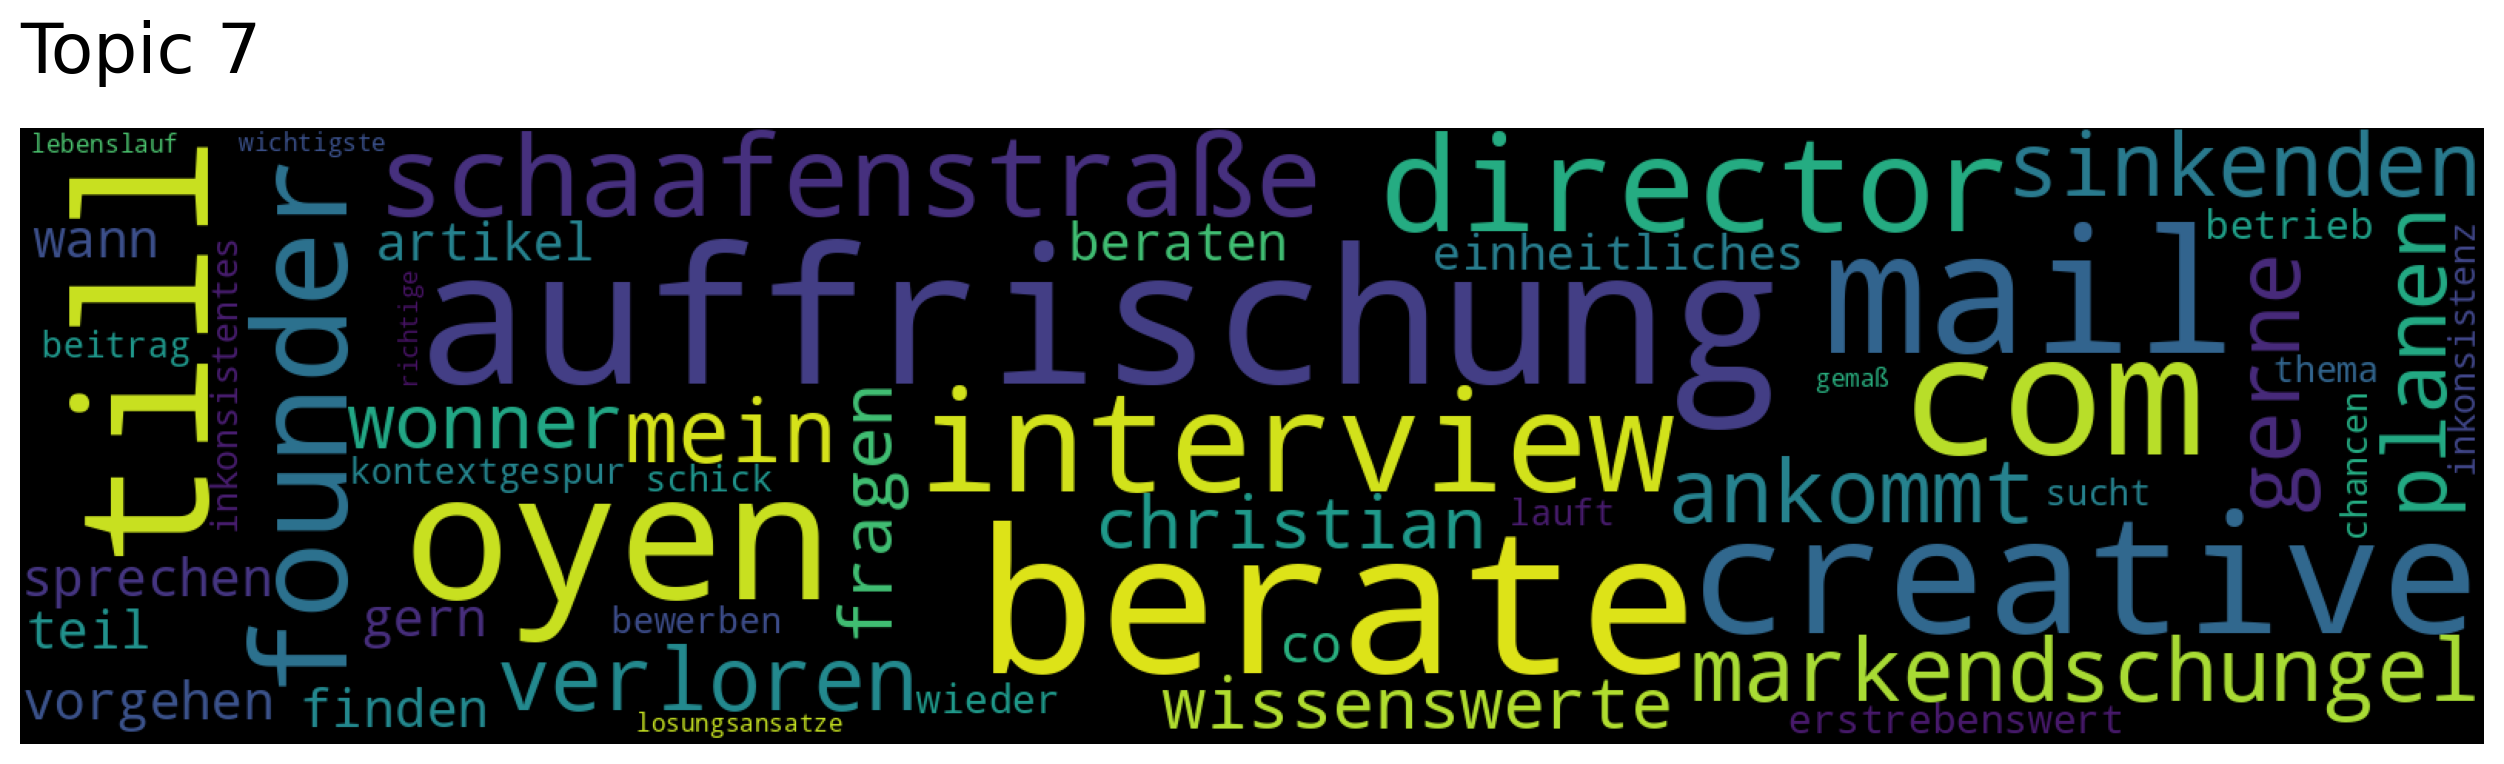

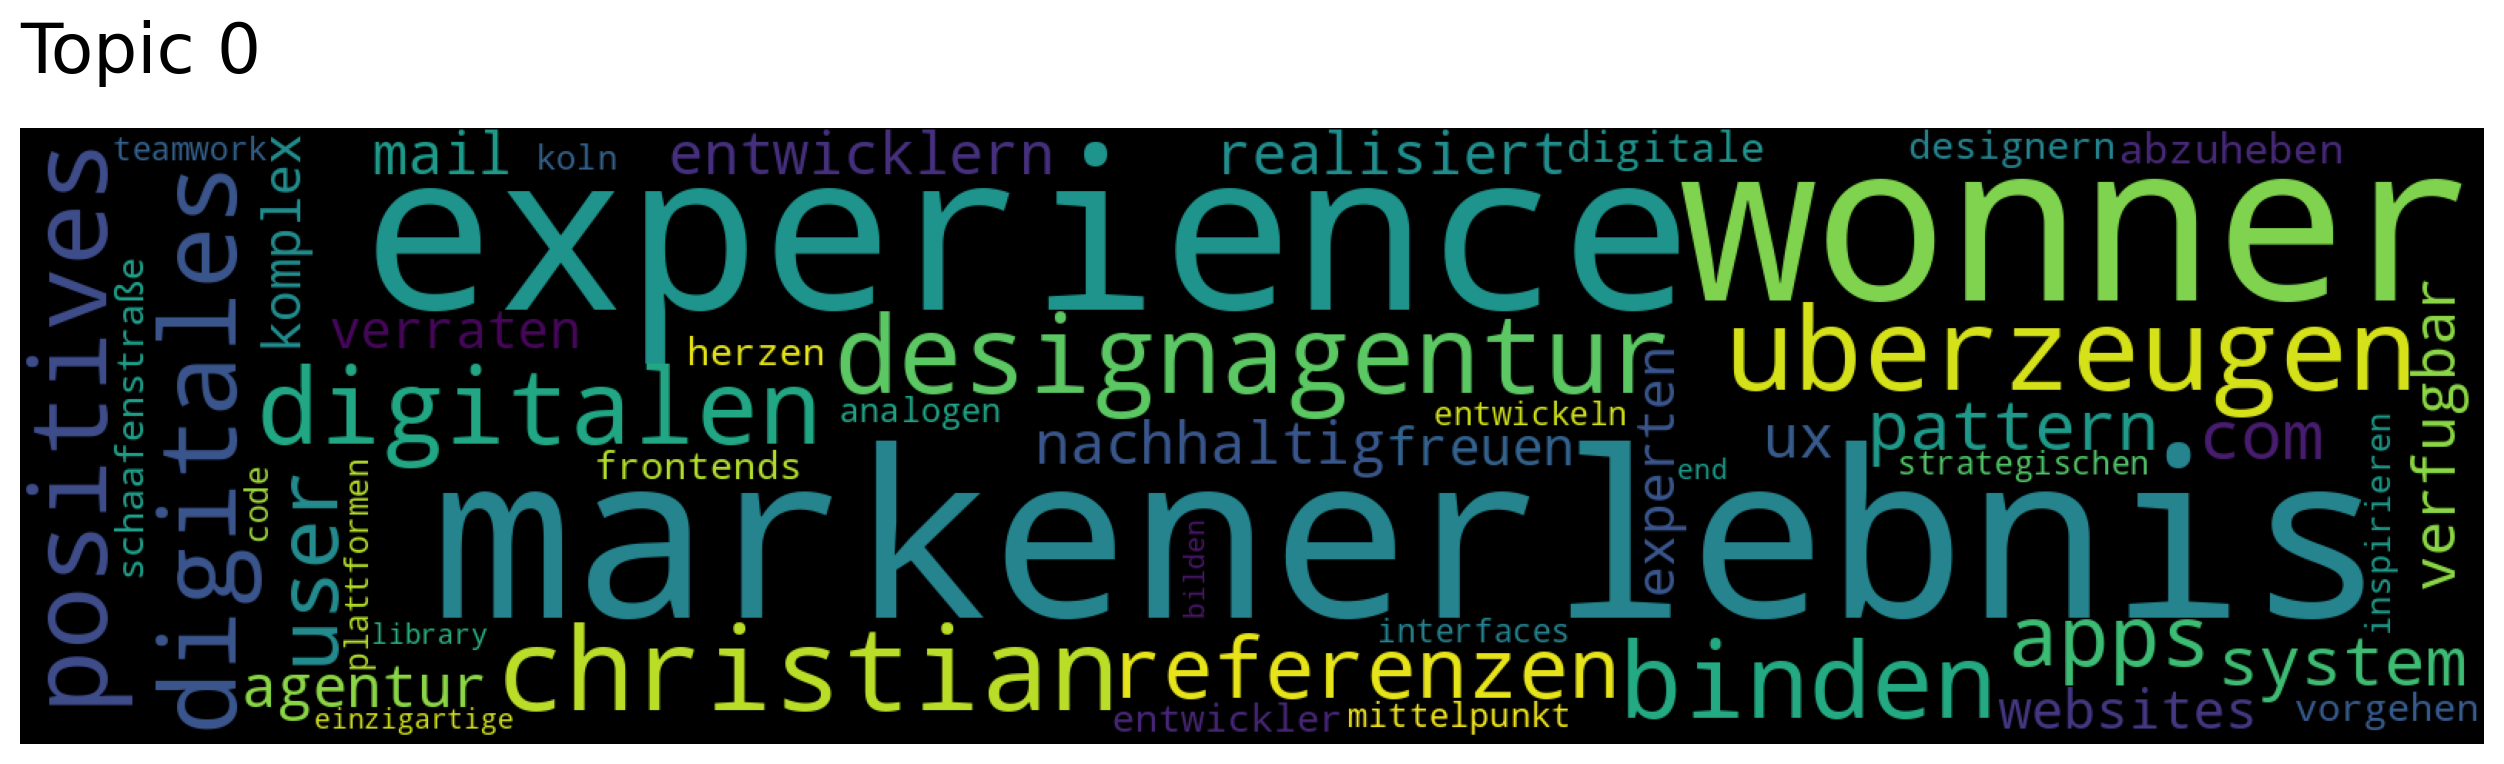

In [14]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as sections:
    for section in sections:
        documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top 3 topics returned for keyword search "radikant":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["radikant"], num_topics=2)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "radikant":')
words, word_scores = model.similar_words(keywords=["radikant"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

passages = []
with jsonlines.open('page_content.jsonl') as reader:
    for page in reader:
        #Add all paragraphs
        passages.extend(page['paragraphs'])

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))